In [1]:
import pandas as pd
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
from utils import * 
import xarray

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential

2022-11-14 22:56:23.444976: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
cwd = os.getcwd()
train_path = "data/train/"
test_path = "data/test/"

# Training set
train_files    = ["mantua"]
X_train_xr, _  = prepare_predictor(train_files,train_path)
y_train_xr, _  = prepare_predictand(train_files,train_path)

# Test set
X_test_xr, _ = prepare_predictor('water', data_path=test_path,time_reindex=False)
y_test_xr, _ = prepare_predictand('water',data_path=test_path,time_reindex=False)

In [3]:
y_train_xr

<xarray.Dataset>
Dimensions:                 (time: 11196, latitude: 1, longitude: 1)
Coordinates:
  * time                    (time) int64 0 1 2 3 4 ... 11192 11193 11194 11195
  * latitude                (latitude) float64 39.77
  * longitude               (longitude) float64 -75.14
Data variables:
    ambientTemperature      (time, latitude, longitude) float64 28.62 ... 71.43
    moduleTemperature       (time, latitude, longitude) float64 38.86 ... 69.67
    planeOfArrayIrradiance  (time, latitude, longitude) float64 795.8 ... 3.574

In [4]:
X_train = X_train_xr["ssrd"].stack(dim=["latitude", "longitude"]).to_numpy()
X_test = X_test_xr["ssrd"].stack(dim=["latitude", "longitude"]).to_numpy()



y_train = y_train_xr["planeOfArrayIrradiance"].stack(dim=["latitude", "longitude"]).to_numpy()
y_test = y_test_xr["planeOfArrayIrradiance"].stack(dim=["latitude", "longitude"]).to_numpy()

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(11196, 169) (11196, 1) (11196, 169) (11196, 1)


In [5]:
# Fix nans
# Confirm nans pattern
for i in range(X_train.shape[0]):
    assert(np.all(np.isnan(X_train[0]) == np.isnan(X_train[i])))
    
# Confirm nans pattern
for i in range(X_train.shape[0]):
    assert(np.all(np.isnan(X_train[0]) == np.isnan(X_test[i])))

nans_mask = np.isnan(X_train[0])

print(nans_mask)

if X_train.shape[1] == 169:
    X_train = X_train[:, ~nans_mask]
    X_test = X_test[:, ~nans_mask]
    
    y_train = np.nan_to_num(y_train, nan=0)
    y_test = np.nan_to_num(y_test, nan=0)
    
print(X_train.shape, X_test.shape)

[False False False  True False False False False False  True False False
 False False False False  True False False False False False  True False
 False False False False False  True False False False False False  True
 False False False  True  True  True  True  True  True  True  True  True
  True  True  True  True False False False  True False False False False
 False  True False False False False False False  True False False False
 False False  True False False False False False False  True False False
 False False False  True False False False False False False  True False
 False False False False  True False False False False False False  True
 False False False False False  True False False False  True  True  True
  True  True  True  True  True  True  True  True  True  True False False
 False  True False False False False False  True False False False False
 False False  True False False False False False  True False False False
 False False False  True False False False False Fa

x_train values


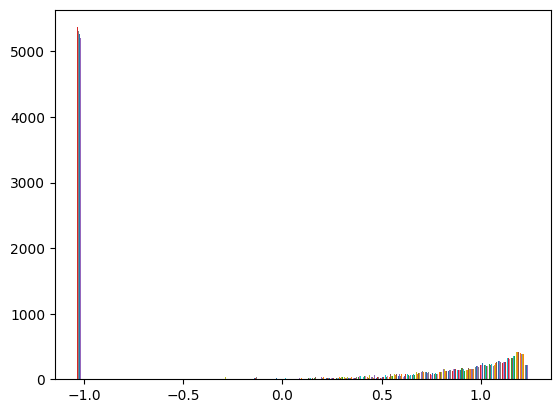

X_test values


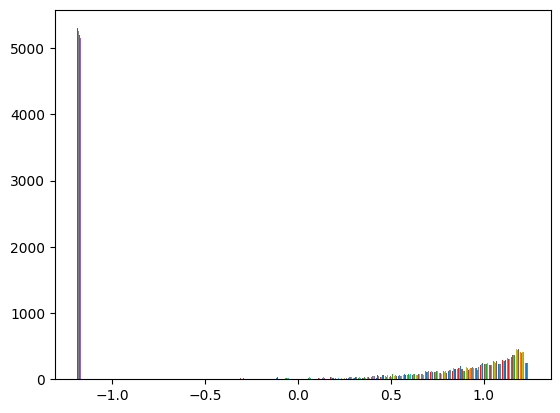

y_train values


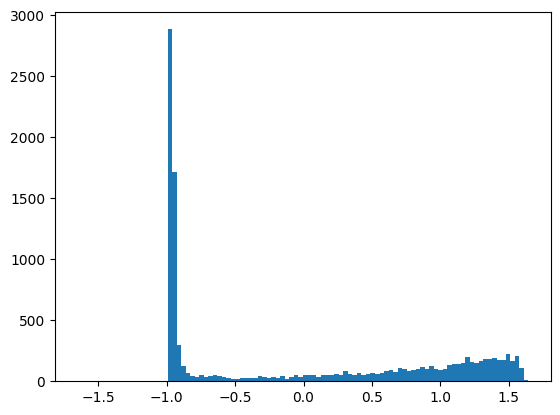

y_test values


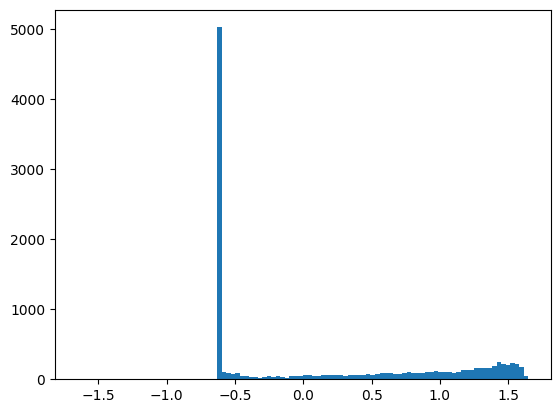

In [9]:
print('x_train values')
plt.hist(X_train, bins=100)
plt.show()

print('X_test values')
plt.hist(X_test, bins=100)
plt.show()


print('y_train values')
plt.hist(y_train, bins=100)
plt.show()



print('y_test values')
plt.hist(y_test, bins=100)
plt.show()


In [7]:
print(np.count_nonzero(np.isnan(y_test)))
np.count_nonzero(np.isnan(np.log(y_train + 1)))

0


0

In [8]:
# Standardization
X_train = np.log(X_train + 1)
assert(np.count_nonzero(np.isnan(X_train)) == 0)
X_test = np.log(X_test + 1)
assert(np.count_nonzero(np.isnan(X_test)) == 0)
y_train = np.log(y_train + 1)
assert(np.count_nonzero(np.isnan(y_train)) == 0)
y_test = np.log(y_test + 1)
assert(np.count_nonzero(np.isnan(y_test)) == 0)

# instead of xtrain mean, i would have to calculate the means for each variable seperately
mean, std = X_train.mean(), X_train.std()

X_train   = (X_train - mean)/std
X_test    = (X_test - mean)/std


mean, std = y_train.mean(), y_train.std()

y_train = (y_train - mean) / std
y_test = (y_test - mean) / std

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)


[[ True]
 [ True]
 [ True]
 ...
 [ True]
 [ True]
 [ True]]
(11196, 121) (11196, 1)
(11196, 121) (11196, 1)


In [40]:
# set hyperparameters
n_neuron       = 128
activation     = 'relu'
num_epochs     = 48
learning_rate  = 0.005
minibatch_size = 64
model_num      = 1

#create the model
model = Sequential()

model.add(Dense(n_neuron,  activation=activation,input_shape=(X_train.shape[1],))) #  the 1st hidden layer 
model.add(Dense(n_neuron,  activation=activation)) # the 2nd hidden layer
# model.add(Dense(n_neuron,  activation=activation)) # the 3rd hidden layer
model.add(Dense(y_train.shape[1],  activation='linear')) # the output layer

model.compile(loss='mse',optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate))

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 128)               15616     
                                                                 
 dense_21 (Dense)            (None, 128)               16512     
                                                                 
 dense_22 (Dense)            (None, 1)                 129       
                                                                 
Total params: 32,257
Trainable params: 32,257
Non-trainable params: 0
_________________________________________________________________


In [41]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history = model.fit(X_train, y_train, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split = 0.2,
                    verbose         = 1,
                    callbacks       = [early_stop])

print('\nFinal test eval on different site:')
model.evaluate(X_test, y_test)


Epoch 1/48
140/140 [==============================] - 0s 1ms/step - loss: 0.9990 - val_loss: 1.2079
Epoch 2/48
140/140 [==============================] - 0s 965us/step - loss: 0.9854 - val_loss: 1.1139
Epoch 3/48
140/140 [==============================] - 0s 968us/step - loss: 0.9788 - val_loss: 1.0772
Epoch 4/48
140/140 [==============================] - 0s 967us/step - loss: 0.9810 - val_loss: 1.2378
Epoch 5/48
140/140 [==============================] - 0s 970us/step - loss: 0.9738 - val_loss: 1.1395
Epoch 6/48
140/140 [==============================] - 0s 954us/step - loss: 0.9744 - val_loss: 1.1421
Epoch 7/48
140/140 [==============================] - 0s 956us/step - loss: 0.9701 - val_loss: 1.0891
Epoch 8/48
140/140 [==============================] - 0s 975us/step - loss: 0.9704 - val_loss: 1.0751
Epoch 9/48
140/140 [==============================] - 0s 970us/step - loss: 0.9697 - val_loss: 1.1212
Epoch 10/48
140/140 [==============================] - 0s 953us/step - loss: 0.9697 

0.7718290686607361

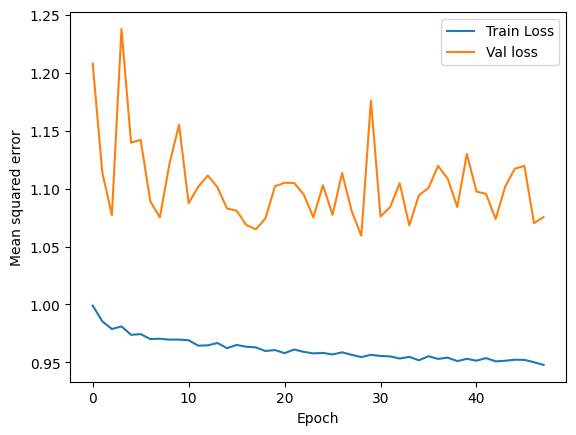

In [44]:
plot_history(history)

In [45]:
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

In [46]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(os.path.join(model_path,'NN_model.h5'))

In [47]:
# reload the saved model
model = load_model(os.path.join(model_path,'NN_model.h5'))

In [48]:
coords_mantua = {'lon' : 39.766038926962466, 'lat' : -75.14202657295235}
coords_west = {'lon' : 41.13935584322975, 'lat' : -73.52551929903115}
coords_water = {'lon' : 39.75493159954764, 'lat' : -74.88289845779185}

In [50]:
y_test_pre = model.predict(X_test)

350/350 [==============================] - 0s 458us/step


In [54]:
y_test_pre

array([[0.00688066],
       [0.00693274],
       [0.00693274],
       ...,
       [0.08520833],
       [0.08520833],
       [0.08520833]], dtype=float32)

In [51]:
df_test = pd.DataFrame(y_test_xr["directIrradiance"].stack(dim=["latitude", "longitude"]),columns=["y_actual"],index=X_test_xr["time"])
df_test["y_predict"] = y_test_pre
df_test

KeyError: 'directIrradiance'

In [27]:
df_test[50:100]

NameError: name 'df_test' is not defined